In [1]:
# Date  : Feb 21, 2023
# Note  : STA 542 Hear Rate variability: midterm report
# Author: EC, EF, SB
# Cotact: soumak.bhattacharjee@duke.edu

In [2]:
import datetime
import numpy as np                   
import glob, os                      # Operatin system commands
import pandas as pd
import time                          # Time operations

In [3]:
# Directory structure
course_dir=os.path.abspath('../');   # Course directory
code_dir=os.getcwd();                # Code directory
data_path=code_dir+'/Data/'          # Data directory

files=os.listdir(data_path);         # List of files

# Prints
fileCounter = len(glob.glob1(data_path,"*.txt"))
print( "Course directory:", course_dir); print( "Current directory:",code_dir); 
print(fileCounter);

Course directory: /hpc/group/tcfdg/sb692/WorkFolder/Courses/STA542TSA
Current directory: /hpc/group/tcfdg/sb692/WorkFolder/Courses/STA542TSA/Project
56


In [4]:
# Sample size, etc
num_files=fileCounter;                # RRI, BIS for each patient
num_patients=fileCounter//2;          # num patients
print('Files missing!') if (num_files%2 ==1) else print('Using data for %d patients' % num_patients);

# List of patients' file names
i=0; patients_fn=[];
for nm in glob.glob(data_path+'*.txt'):
    patients_fn.append(nm[65:-7]);
    
patients_fn=list(set(patients_fn));# Unique values, length: num_patients
#range(num_files):# patients_fn.append(files[i][:-7]); #patients_fn=list(set(patients_fn));   


# Time, data
time_duration=16*60;                 # total data duration in seconds        
sampling_rate=4;                     # Hz
sampled_points=time_duration*sampling_rate;
                                     # size of data
print('data size: ',sampled_points)
# for i in patients_fn: # print(i[65:-7]);

print(datetime.datetime.now());

Using data for 28 patients
data size:  3840
2023-04-06 08:54:28.437910


In [6]:
# Data input etc.
start_t = time.perf_counter();

RRI=pd.DataFrame();          # Dictionary holding patient info in data_frames
BIS=pd.DataFrame();

for j in range(num_patients):
    i=patients_fn[j]
    
    rri_fn=data_path+i+'RRI.txt'
    bis_fn=data_path+i+'BIS.txt'
    # print(rri_fn)

    patient_RRI=pd.read_table(rri_fn,sep=",",names=["time","signal"])
    patient_BIS=pd.read_table(bis_fn,sep=",",names=["time","signal"])
    
    if (j==0):
        BIS['id_time'] = patient_BIS.index;
        RRI['id_time'] = patient_RRI.index;
        
        BIS['surgery']=np.where(BIS['id_time']<BIS['id_time'][1440],0,1);
        RRI['surgery']=np.where(RRI['id_time']<RRI['id_time'][1440],0,1);
        
    RRI[j] = patient_RRI["signal"];    
    BIS[j] = patient_BIS["signal"];
    
finish_t = time.perf_counter()
print(f'Finished in {round(finish_t-start_t, 2)} second(s)');
print(datetime.datetime.now());

Finished in 1.88 second(s)
2023-04-06 08:54:50.692744


In [7]:
# print(RRI); print('------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------'); print(BIS);
print(BIS.shape,RRI.shape);
print(datetime.datetime.now());

(3841, 30) (3841, 30)
2023-04-06 08:55:28.907071


### ADF tests

In [8]:
# ADF test
# Code source: https://www.analyticsvidhya.com/blog/2021/04/how-to-check-stationarity-of-data-in-python/

start_t = time.perf_counter();

from statsmodels.tsa.stattools import adfuller

preop_BIS_test=[]; Op_BIS_test=[];   BIS_test=[];
preop_RRI_test=[]; Op_RRI_test=[];   RRI_test=[];

for i in range(num_patients):
    # BIS
    dftest = adfuller(BIS[BIS['id_time']< BIS['id_time'][1440]][i], regression='ct',autolag='AIC');  preop_BIS_test.append(dftest);
    dftest = adfuller(BIS[BIS['id_time']>=BIS['id_time'][1440]][i],regression='ct',autolag='AIC');   Op_BIS_test.append(dftest);
    dftest = adfuller(BIS[:][i],regression='ct',autolag='AIC');   BIS_test.append(dftest);
    # RRI
    dftest = adfuller(RRI[RRI['id_time']< RRI['id_time'][1440]][i], regression='ct',autolag='AIC');  preop_RRI_test.append(dftest);
    dftest = adfuller(RRI[RRI['id_time']>=RRI['id_time'][1440]][i],regression='ct',autolag='AIC');   Op_RRI_test.append(dftest);
    dftest = adfuller(RRI[:][i],regression='ct',autolag='AIC');   RRI_test.append(dftest);
    
finish_t = time.perf_counter()
print(f'Finished in {round(finish_t-start_t, 2)} second(s)');
print(datetime.datetime.now());

print('Test data BIS, RRI: in preop_test:',len(preop_BIS_test),len(preop_RRI_test),',   Op_test:',len(Op_BIS_test),len(Op_RRI_test));  

Finished in 14.41 second(s)
2023-04-06 08:55:51.682338
Test data BIS, RRI: in preop_test: 28 28 ,   Op_test: 28 28


In [9]:
# Add stationarity check to data-set column
bis_preop_adf=[]; bis_Op_adf=[]; bis_adf=[];
rri_preop_adf=[]; rri_Op_adf=[]; rri_adf=[];

for i in range(num_patients):
    # BIS
    bis_preop_adf.append(0) if  preop_BIS_test[i][1] > 0.05 else bis_preop_adf.append(1); # 0 for H0 null hypothesis i.e. TS non-stationary
    bis_Op_adf.append(0) if Op_BIS_test[i][1] > 0.05 else bis_Op_adf.append(1);        # 1 for alternative hypothesis
    bis_adf.append(0) if BIS_test[i][1] > 0.05 else bis_adf.append(1);
    
    # RRI
    rri_preop_adf.append(0) if  preop_RRI_test[i][1] > 0.05 else rri_preop_adf.append(1); # 0 for H0 null hypothesis i.e. TS non-stationary
    rri_Op_adf.append(0) if Op_RRI_test[i][1] > 0.05 else rri_Op_adf.append(1);
    rri_adf.append(0) if RRI_test[i][1] > 0.05 else rri_adf.append(1);

print(len(rri_adf),num_patients)
    
# print('Variables: Test Statistic, p-value')
for i in range(num_patients):
    pat='patient '+str(i).zfill(2)
    print(pat, 'BIS - preop %d, op %d, net %d, RRI - preop %d, op %d, net %d' % (bis_preop_adf[i], bis_Op_adf[i], bis_adf[i], rri_preop_adf[i], rri_Op_adf[i], rri_adf[i]));
#     print(pat,'BIS - preop (%4.2f, %7.4f)'%preop_BIS_test[i][0:2],'.       op (%4.2f, %7.4f)'%Op_BIS_test[i][1], 'RRI - preop (%4.2f, %7.4f)'%preop_RRI_test[i][0:2],', op (%4.2f, %7.4f)'%Op_RRI_test[i][0:2])
# print(RRI[RRI['id_time']>=RRI['id_time'][1440]][1].shape,BIS[BIS['id_time']>=BIS['id_time'][1440]][i].shape)

28 28
patient 00 BIS - preop 1, op 1, net 1, RRI - preop 1, op 0, net 1
patient 01 BIS - preop 1, op 1, net 1, RRI - preop 0, op 1, net 1
patient 02 BIS - preop 1, op 0, net 0, RRI - preop 0, op 0, net 0
patient 03 BIS - preop 1, op 0, net 0, RRI - preop 1, op 0, net 0
patient 04 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient 05 BIS - preop 0, op 0, net 0, RRI - preop 0, op 0, net 0
patient 06 BIS - preop 1, op 1, net 1, RRI - preop 0, op 1, net 1
patient 07 BIS - preop 1, op 1, net 1, RRI - preop 0, op 1, net 0
patient 08 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient 09 BIS - preop 0, op 1, net 1, RRI - preop 1, op 0, net 0
patient 10 BIS - preop 1, op 1, net 1, RRI - preop 0, op 1, net 0
patient 11 BIS - preop 1, op 1, net 1, RRI - preop 0, op 0, net 0
patient 12 BIS - preop 1, op 1, net 1, RRI - preop 0, op 0, net 0
patient 13 BIS - preop 1, op 1, net 0, RRI - preop 0, op 0, net 0
patient 14 BIS - preop 1, op 1, net 1, RRI - preop 0, op 0, net 0
pati

In [ ]:
## ADF || c, AIC
# Variables: Test Statistic, p-value, 
# patient0 BIS - preop (-1.76,  0.3985) , op (-5.32,  0.0000) RRI - preop (-4.39,  0.0003) , op (-4.57,  0.0001)
# patient1 BIS - preop (-4.83,  0.0000) , op (-2.59,  0.0951) RRI - preop (-2.81,  0.0570) , op (-2.70,  0.0742)
# patient2 BIS - preop (-4.40,  0.0003) , op (-2.19,  0.2114) RRI - preop (-3.04,  0.0310) , op (-1.09,  0.7179)

# ADF || ct, AIC
# patient0 BIS - preop     st , op     st. RRI - preop     st, op     st
# patient1 BIS - preop     st , op non-st. RRI - preop non-st, op     st
# patient2 BIS - preop     st , op non-st. RRI - preop     st, op non-st

In [10]:
# ADF results
# Not looking at these now

preop_BIS_out=[]; Op_BIS_out=[];          # ADF output
preop_RRI_out=[]; Op_RRI_out=[]; 

preop_cv=pd.Series(); Op_cv=pd.Series();  # Critical p-values

for i in range(num_patients):
    # Pre-op
    dftest=preop_BIS_test[i]; dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used']);
    if (i==0):
        for key,value in dftest[4].items(): preop_cv['critical value (%s)'%key]= value 
    preop_BIS_out.append(dfoutput);
    
    # Op
    dftest=Op_BIS_test[i]; dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used']);
    if (i==0):
        for key,value in dftest[4].items(): Op_cv['critical value (%s)'%key]= value 
    Op_BIS_out.append(dfoutput);

print('Output data in preop_BIS_out:',len(preop_BIS_out),',   Op_BIS_out:',len(Op_BIS_out));
# print('-------------------------------------------------------------------------');
# print(dftest);
# print(dftest[1]);

Output data in preop_BIS_out: 28 ,   Op_BIS_out: 28


<ipython-input-10-66dec46d6d26>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  preop_cv=pd.Series(); Op_cv=pd.Series();  # Critical p-values


In [113]:
# Print outputs concisely
print('Pre-op series BIS:')
print('      Critical value:')
print(preop_cv)

for i in range(num_patients):
    print('...............');
    print('Patient'+str(i));
    print(preop_BIS_out[i]);

# for i in range(num_patients):
print('------------------------------------------------------------------------------');

print('Op series BIS:')
print('      Critical value:')
print(Op_cv)

for i in range(num_patients):
    print('...............');
    print('Patient'+str(i));
    print(Op_BIS_out[i]);


Pre-op series BIS:
      Critical value:
critical value (1%)    -3.434973
critical value (5%)    -2.863582
critical value (10%)   -2.567857
dtype: float64
...............
Patient0
Test Statistic                   -4.401137
p-value                           0.000295
#lags used                       22.000000
number of observations used    1417.000000
dtype: float64
...............
Patient1
Test Statistic                   -1.763855
p-value                           0.398548
#lags used                       22.000000
number of observations used    1417.000000
dtype: float64
...............
Patient2
Test Statistic                   -4.826387
p-value                           0.000048
#lags used                       22.000000
number of observations used    1417.000000
dtype: float64
------------------------------------------------------------------------------
Op series BIS:
      Critical value:
critical value (1%)    -3.433103
critical value (5%)    -2.862756
critical value (10%)   -2.5

Test        : ADF
Test for    : Stationarity check
Data        : BIS
Penalisation: BIC
Summary     : 
             pre-op: Patients 0,2 stationary p<1%, 
                     Patient 1 non-stationary p>10%
             Op    : Patient 0 non-stationary p>20%
                     Patients 1,2 stationary p<1%, p~4%
Penalisation: AIC
Summary     : 
             pre-op: Patients 0,2 stationary p<1%, 
                     Patient 1 non-stationary p>10%
             Op    : Patient 0, 2 non-stationary p>20%, p~9%
                     Patients 1 stationary p<1%

## KPSS test

In [11]:
# KPSS
# Code source: https://www.statology.org/kpss-test-in-python/
from statsmodels.tsa.stattools import kpss

start_t = time.perf_counter();


kpreop_BIS_test=[]; kOp_BIS_test=[]; kBIS_test=[];
kpreop_RRI_test=[]; kOp_RRI_test=[]; kRRI_test=[]; 

for i in range(num_patients):
    # BIS
    dftest = kpss(BIS[BIS['id_time']<BIS['id_time'][1440]][i],regression='ct',nlags='auto');    kpreop_BIS_test.append(dftest);
    dftest = kpss(BIS[BIS['id_time']>=BIS['id_time'][1440]][i],regression='ct',nlags='auto');   kOp_BIS_test.append(dftest);
    dftest = kpss(BIS[:][i],regression='ct',nlags='auto');                                      kBIS_test.append(dftest);
    # RRI
    dftest = kpss(RRI[RRI['id_time']<RRI['id_time'][1440]][i],regression='ct',nlags='auto');    kpreop_RRI_test.append(dftest);
    dftest = kpss(RRI[RRI['id_time']>=RRI['id_time'][1440]][i],regression='ct',nlags='auto');   kOp_RRI_test.append(dftest);
    dftest = kpss(RRI[:][i],regression='ct',nlags='auto');                                      kRRI_test.append(dftest);
    
    
finish_t = time.perf_counter()
print(f'Finished in {round(finish_t-start_t, 2)} second(s)');
print(datetime.datetime.now());

print('Test data BIS, RRI: in preop_test:',len(kpreop_BIS_test),len(kpreop_RRI_test),',   Op_test:',len(kOp_BIS_test),len(kOp_RRI_test));  


/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the r

Finished in 0.33 second(s)
2023-04-06 09:33:50.797319
Test data BIS, RRI: in preop_test: 28 28 ,   Op_test: 28 28


/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the r

In [12]:
# Add stationarity check to data-set column
bis_preop_kpss=[]; bis_Op_kpss=[]; bis_kpss=[];
rri_preop_kpss=[]; rri_Op_kpss=[]; rri_kpss=[];

for i in range(num_patients):
    # BIS
    bis_preop_kpss.append(0) if kpreop_BIS_test[i][1] >= 0.05 else bis_preop_kpss.append(1); # 0 for H0 null hypothesis i.e. TS stationary
    bis_Op_kpss.append(0) if kOp_BIS_test[i][1] >= 0.05 else bis_Op_kpss.append(1);          # 1 for alternative hypothesis i.e. non-stationary
    bis_kpss.append(0) if kBIS_test[i][1] >= 0.05 else bis_kpss.append(1);
    
    # RRI
    rri_preop_kpss.append(0) if kpreop_RRI_test[i][1] >= 0.05 else rri_preop_kpss.append(1); # 0 for H0 null hypothesis i.e. TS stationary
    rri_Op_kpss.append(0) if kOp_RRI_test[i][1] >= 0.05 else rri_Op_kpss.append(1);
    rri_kpss.append(0) if kRRI_test[i][1] >= 0.05 else rri_kpss.append(1);

print(len(rri_kpss),num_patients)
# print('Variables: Test Statistic, p-value')
for i in range(num_patients):
    pat='patient'+str(i).zfill(2)
    print(pat, 'BIS - preop %d, op %d, net %d, RRI - preop %d, op %d, net %d' % (bis_preop_kpss[i], bis_Op_kpss[i], bis_kpss[i], rri_preop_kpss[i], rri_Op_kpss[i], rri_kpss[i]));
    # print(pat,'BIS - preop (%4.2f, %7.4f)'%kpreop_BIS_test[i][0:2],', op (%4.2f, %7.4f)'%kOp_BIS_test[i][0:2], 'RRI - preop (%4.2f, %7.4f)'%kpreop_RRI_test[i][0:2],', op (%4.2f, %7.4f)'%kOp_RRI_test[i][0:2])
#     print('BIS:'); print(kpreop_BIS_test[i], kOp_BIS_test[i]);
#     print('RRI:'); print(kpreop_BIS_test[i], kOp_BIS_test[i]);


28 28
patient00 BIS - preop 1, op 0, net 1, RRI - preop 1, op 1, net 1
patient01 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient02 BIS - preop 0, op 1, net 1, RRI - preop 1, op 1, net 1
patient03 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient04 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient05 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient06 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient07 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient08 BIS - preop 0, op 0, net 1, RRI - preop 1, op 1, net 1
patient09 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient10 BIS - preop 0, op 1, net 1, RRI - preop 1, op 0, net 1
patient11 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient12 BIS - preop 0, op 1, net 0, RRI - preop 1, op 1, net 1
patient13 BIS - preop 1, op 1, net 1, RRI - preop 1, op 1, net 1
patient14 BIS - preop 1, op 1, net 0, RRI - preop 1, op 1, net 1
patient15 BIS - pre

In [21]:
## ADF || c, AIC
# Variables: Test Statistic, p-value, 
# patient0 BIS - preop (-1.76,  0.3985) , op (-5.32,  0.0000) RRI - preop (-4.39,  0.0003) , op (-4.57,  0.0001)
# patient1 BIS - preop (-4.83,  0.0000) , op (-2.59,  0.0951) RRI - preop (-2.81,  0.0570) , op (-2.70,  0.0742)
# patient2 BIS - preop (-4.40,  0.0003) , op (-2.19,  0.2114) RRI - preop (-3.04,  0.0310) , op (-1.09,  0.7179)

# ADF || ct, AIC
# patient0 BIS - preop     st , op     st. RRI - preop     st, op     st
# patient1 BIS - preop     st , op non-st. RRI - preop non-st, op     st
# patient2 BIS - preop     st , op non-st. RRI - preop     st, op non-st

# KPSS
# Variables: Test Statistic, p-value
# patient0 BIS - preop (0.25,  0.0100) , op (0.36,  0.0100) RRI - preop (0.35,  0.0100) , op (0.46,  0.0100)
# patient1 BIS - preop (0.12,  0.1000) , op (0.83,  0.0100) RRI - preop (0.64,  0.0100) , op (0.72,  0.0100)
# patient2 BIS - preop (0.30,  0.0100) , op (1.11,  0.0100) RRI - preop (0.51,  0.0100) , op (1.14,  0.0100)

# patient0 BIS - preop non-st, op non-st. RRI - preop non-st , op non-st
# patient1 BIS - preop     st, op non-st. RRI - preop non-st , op non-st
# patient2 BIS - preop non-st, op non-st. RRI - preop non-st , op non-st

# Plot times series

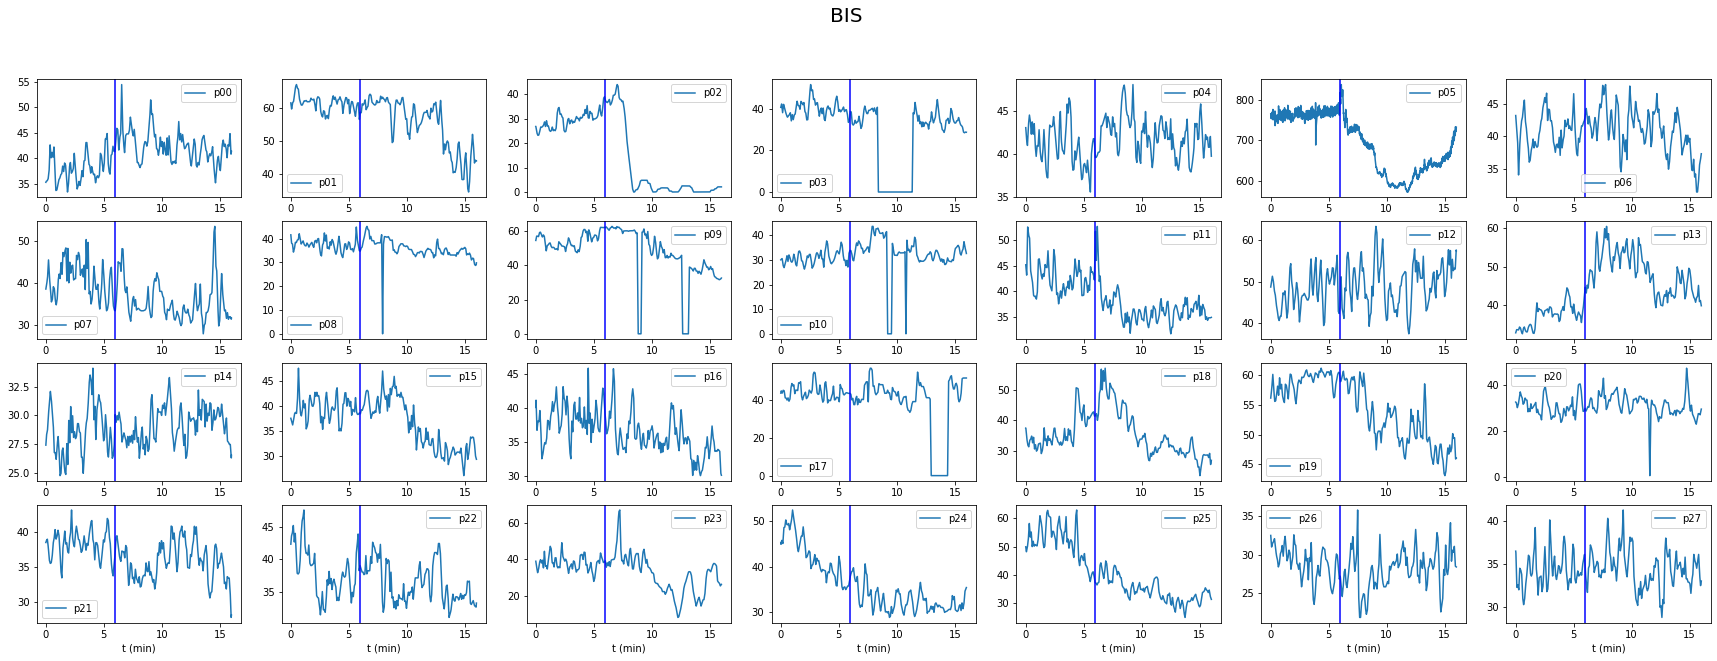

In [34]:
# BIS plots
fig=plt.figure(figsize=(30,10))
fig.suptitle('BIS',fontsize='20')
nc=7; nr=4;
for i in range(num_patients):
    pat='p'+str(i).zfill(2);
    plt.subplot(nr,nc,i+1);
    plt.plot(BIS.index/(sampling_rate*60),BIS[i],label=pat)
    plt.axvline(x = 6, color = 'b')
    plt.legend()
    if (i>=nc*(nr-1)): plt.xlabel('t (min)')
# #plt stuff
# plt.subplot(10,10,2)


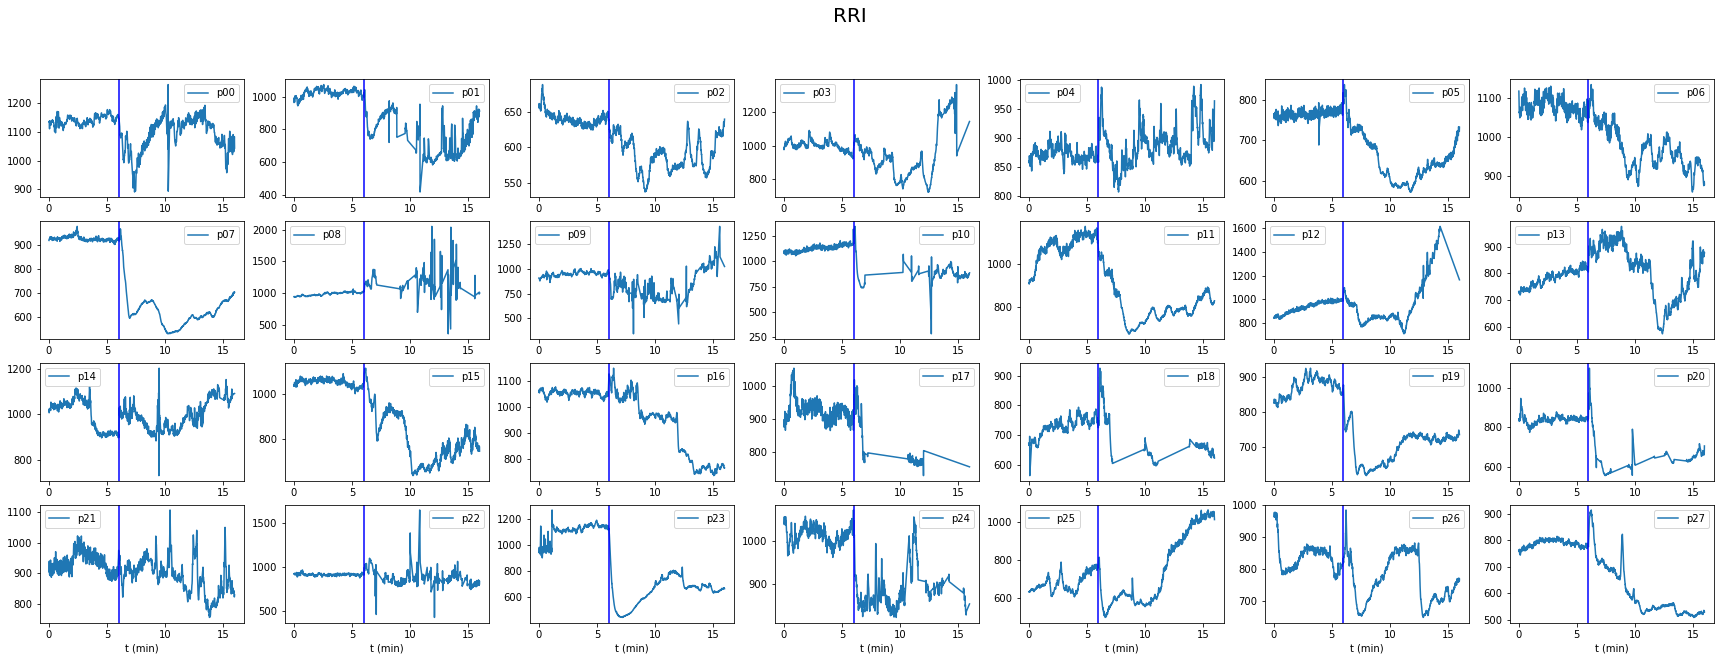

In [48]:
# RRI plots
fig=plt.figure(figsize=(30,10))
fig.suptitle('RRI',fontsize='20')
nc=7; nr=4;
for i in range(num_patients):
    pat='p'+str(i).zfill(2);
    plt.subplot(nr,nc,i+1);
    plt.plot(RRI.index/(sampling_rate*60),RRI[i],label=pat)
    plt.axvline(x = 6, color = 'b')
    plt.legend()
    if (i>=nc*(nr-1)): plt.xlabel('t (min)')
# #plt stuff
# plt.subplot(10,10,2)

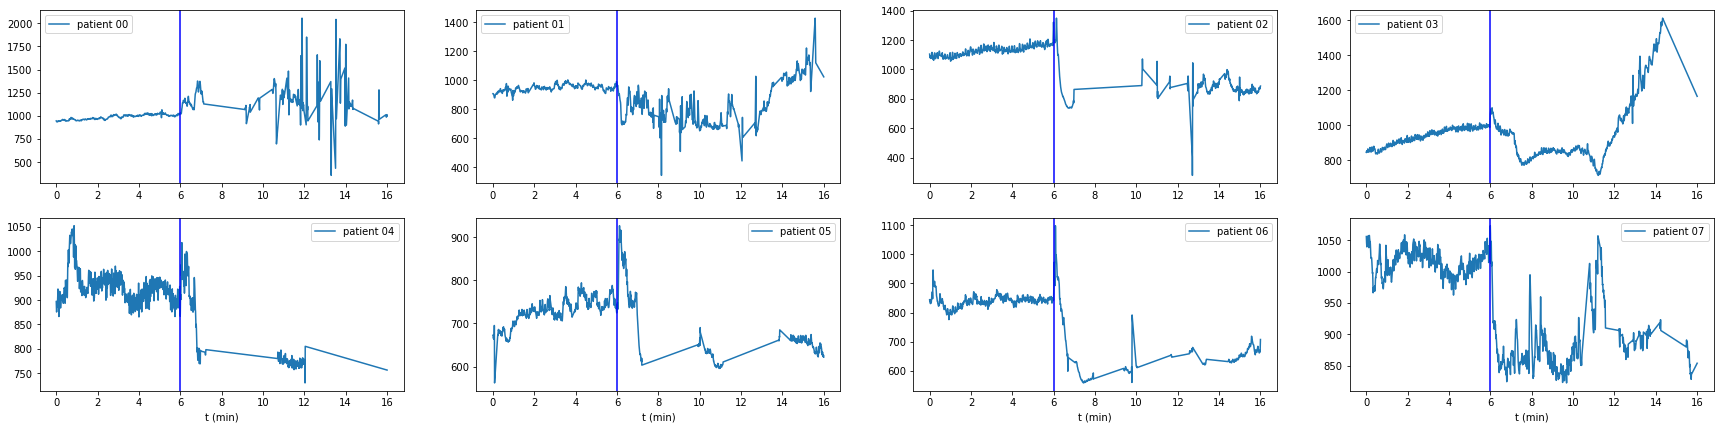

In [55]:
# Selected plots individually
# Plot time series
import matplotlib.pyplot as plt
import seaborn as sns 

missing_data_indexes=[8,9,10,12,17,18,20,24];

plt.figure(figsize=(30,7));
nc=4; nr=2;

for i in range(len(missing_data_indexes)):
    plt.subplot(nr,nc,i+1);
    plt.plot(RRI.index/(sampling_rate*60),RRI[missing_data_indexes[i]],label='patient '+str(i).zfill(2))
    plt.axvline(x = 6, color = 'b')
    plt.legend()
    if (i>=nc*(nr-1)): plt.xlabel('t (min)')
# plt.subplot(122)
# plt.scatter(patient_info.index,patient_info["BIS"], c=patient_info["name"])
# plt.axvline(x = 1440, color = 'b', label = 'axvline - full height')

